In [16]:
import mne
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, AveragePooling2D, Input, BatchNormalization, Activation
from tensorflow.keras.layers import DepthwiseConv2D, SeparableConv2D
from tensorflow.keras.constraints import max_norm


In [17]:
    # Step 3: Prepare data for CNN
edf_file_path = r'15089_2017_08_14_EEG\0_20170814_161604.edf'  
raw = mne.io.read_raw_edf(edf_file_path, preload=True)
raw

Extracting EDF parameters from c:\Users\91820\Downloads\drive-download-20240708T114910Z-001\15089_2017_08_14_EEG\0_20170814_161604.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1230449  =      0.000 ...  4921.796 secs...


<RawEDF | 0_20170814_161604.edf, 32 x 1230450 (4921.8 s), ~300.4 MB, data loaded>

In [18]:
raw = mne.io.read_raw_edf(edf_file_path, preload=True)

# Drop unwanted channels
raw.drop_channels(['EKG2'])

# Apply high-pass and low-pass filters
sfreq = raw.info['sfreq']
nyquist_freq = sfreq / 2
highpass_freq = 0.1  # Example high-pass frequency, adjust as needed
lowpass_freq = min(80, nyquist_freq - 1)  # Example low-pass frequency
raw.filter(l_freq=highpass_freq, h_freq=lowpass_freq, fir_design='firwin', phase='zero')

# Step 1: Define and select specific montage channels
montage_channels = ['FP1', 'FP2', 'F7', 'F8']
raw.pick(montage_channels)


Extracting EDF parameters from c:\Users\91820\Downloads\drive-download-20240708T114910Z-001\15089_2017_08_14_EEG\0_20170814_161604.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1230449  =      0.000 ...  4921.796 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 8251 samples (33.004 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


<RawEDF | 0_20170814_161604.edf, 4 x 1230450 (4921.8 s), ~37.6 MB, data loaded>

In [19]:
data = raw.get_data()

In [20]:
data.shape


(4, 1230450)

In [21]:
n_samples, n_channels, n_times = data.shape[1], data.shape[0], data.shape[1]
print(f"Data shape: {data.shape}")
# data = data.reshape((n_samples, n_channels, n_times, 1))

Data shape: (4, 1230450)


In [27]:
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, SeparableConv2D, BatchNormalization, Activation, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.constraints import max_norm

def EEGNet(nb_classes, Chans=4, Samples=128, dropoutRate=0.5, kernLength=64, F1=16, D=2, F2=32, norm_rate=0.25, dropoutType='Dropout'):
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')

    input1 = Input(shape=(Chans, Samples, 1))

    ##################################################################
    # Block 1
    block1 = Conv2D(F1, (1, kernLength), padding='same', use_bias=False)(input1)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=D)(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = dropoutType(dropoutRate)(block1)

    ##################################################################
    # Block 2
    block2 = SeparableConv2D(F2, (1, 16), use_bias=False, padding='same')(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = dropoutType(dropoutRate)(block2)

    ##################################################################
    # Additional Block (Block 3)
    block3 = SeparableConv2D(F2, (1, 32), use_bias=False, padding='same')(block2)
    block3 = BatchNormalization()(block3)
    block3 = Activation('elu')(block3)
    block3 = AveragePooling2D((1, 4))(block3)
    block3 = dropoutType(dropoutRate)(block3)

    flatten = Flatten(name='flatten')(block3)

    dense = Dense(nb_classes, name='dense', kernel_constraint=max_norm(norm_rate))(flatten)
    softmax = Activation('softmax', name='softmax')(dense)

    return Model(inputs=input1, outputs=softmax)


In [41]:
def process_eeg_data(edf_file_path):
    ##processing is based on steps in Relax pipeline
    import mne
    
    raw = mne.io.read_raw_edf(edf_file_path, preload=True)
    raw.drop_channels(['EKG2'])
    raw.filter(l_freq=0.1, h_freq=80.0)
    
    sfreq = raw.info['sfreq']
    nyquist_freq = sfreq / 2
    highpass_freq = 0.1  # Example high-pass frequency, adjust as needed
    lowpass_freq = min(80, nyquist_freq - 1)  # Example low-pass frequency
    raw.filter(l_freq=highpass_freq, h_freq=lowpass_freq, fir_design='firwin', phase='zero')

    # Step 1: Define and select specific montage channels
    montage_channels = ['FP1', 'FP2', 'F7', 'F8']
    raw.set_eeg_reference(ref_channels=['CZ'])

    raw.pick(montage_channels)
    raw.plot(scalings='auto', title='Re-referenced EEG Channels to CZ', block=True)

    
    
    
    # Convert annotations to events
    events, event_id = mne.events_from_annotations(raw)
    epochs = mne.Epochs(raw, events, event_id, tmin=0, tmax=1.0, baseline=None, preload=True)

    ica = mne.preprocessing.ICA(n_components=4, random_state=97, max_iter=800)
    ica.fit(epochs)
    ica.plot_sources(epochs)
    ica.apply(epochs)

    # Extract the data and labels
    X = epochs.get_data()  # Shape: (n_trials, n_channels, n_times)
    y = epochs.events[:, -1]  # Labels

    # Split the data into train and test sets
    n_trials = X.shape[0]
    split_idx = int(n_trials * 0.8)  # 80-20 train-test split
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Reshape the data to match EEGNet's expected input (Chans, Samples, 1)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

    return X_train, X_test, y_train, y_test

In [42]:
from tensorflow.keras.utils import to_categorical


In [43]:
def apply_cnn_pipeline(edf_file_path):
    # Step 1: Process the EEG data
    X_train, X_test, y_train, y_test = process_eeg_data(edf_file_path)
    
    # Ensure that the labels are one-hot encoded
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    
    # Step 2: Build the EEGNet model
    model = EEGNet(nb_classes=y_train.shape[1], Chans=X_train.shape[1], Samples=X_train.shape[2])
    
    # Compile the model with categorical cross-entropy and accuracy metrics
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Step 3: Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

    # Step 4: Evaluate the model on the test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f'Test accuracy: {test_accuracy * 100:.2f}%')

Extracting EDF parameters from c:\Users\91820\Downloads\drive-download-20240708T114910Z-001\15089_2017_08_14_EEG\0_20170814_161604.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1230449  =      0.000 ...  4921.796 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 8251 samples (33.004 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 8251 samples (33.004 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.2s


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


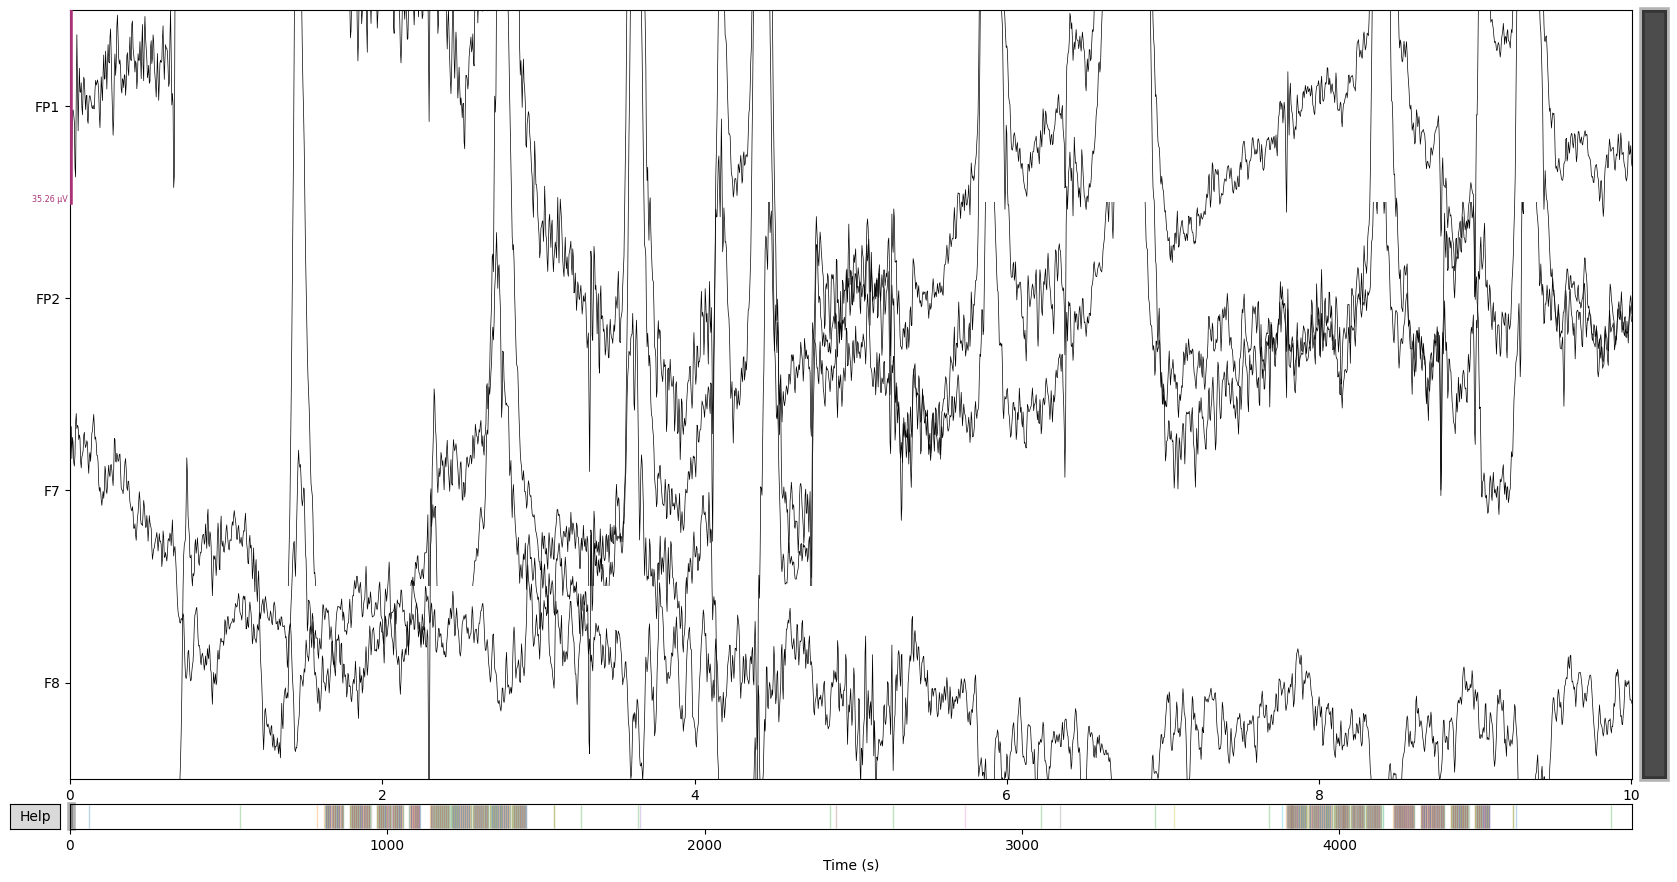

Used Annotations descriptions: ['TRIGGER EVENT A', 'TRIGGER EVENT B', 'TRIGGER EVENT C', 'TRIGGER EVENT D', 'TRIGGER EVENT E', 'TRIGGER EVENT F', 'TRIGGER EVENT G', 'TRIGGER EVENT H', 'TRIGGER EVENT I', 'TRIGGER EVENT J', 'TRIGGER EVENT M', 'TRIGGER EVENT N', 'TRIGGER EVENT O', 'TRIGGER EVENT P', 'TRIGGER EVENT Q', 'TRIGGER EVENT R', 'TRIGGER EVENT S', 'TRIGGER EVENT T', 'TRIGGER EVENT U', 'TRIGGER EVENT X', 'TRIGGER EVENT Z', 'Unknown Event']
Not setting metadata
1003 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1003 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components
Fitting ICA took 1.5s.
Not setting metadata
1003 matching events found
No baseline correction applied
0 projection items activated


C:\Users\91820\AppData\Local\Temp\ipykernel_9600\2960899337.py:30: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  ica.plot_sources(epochs)


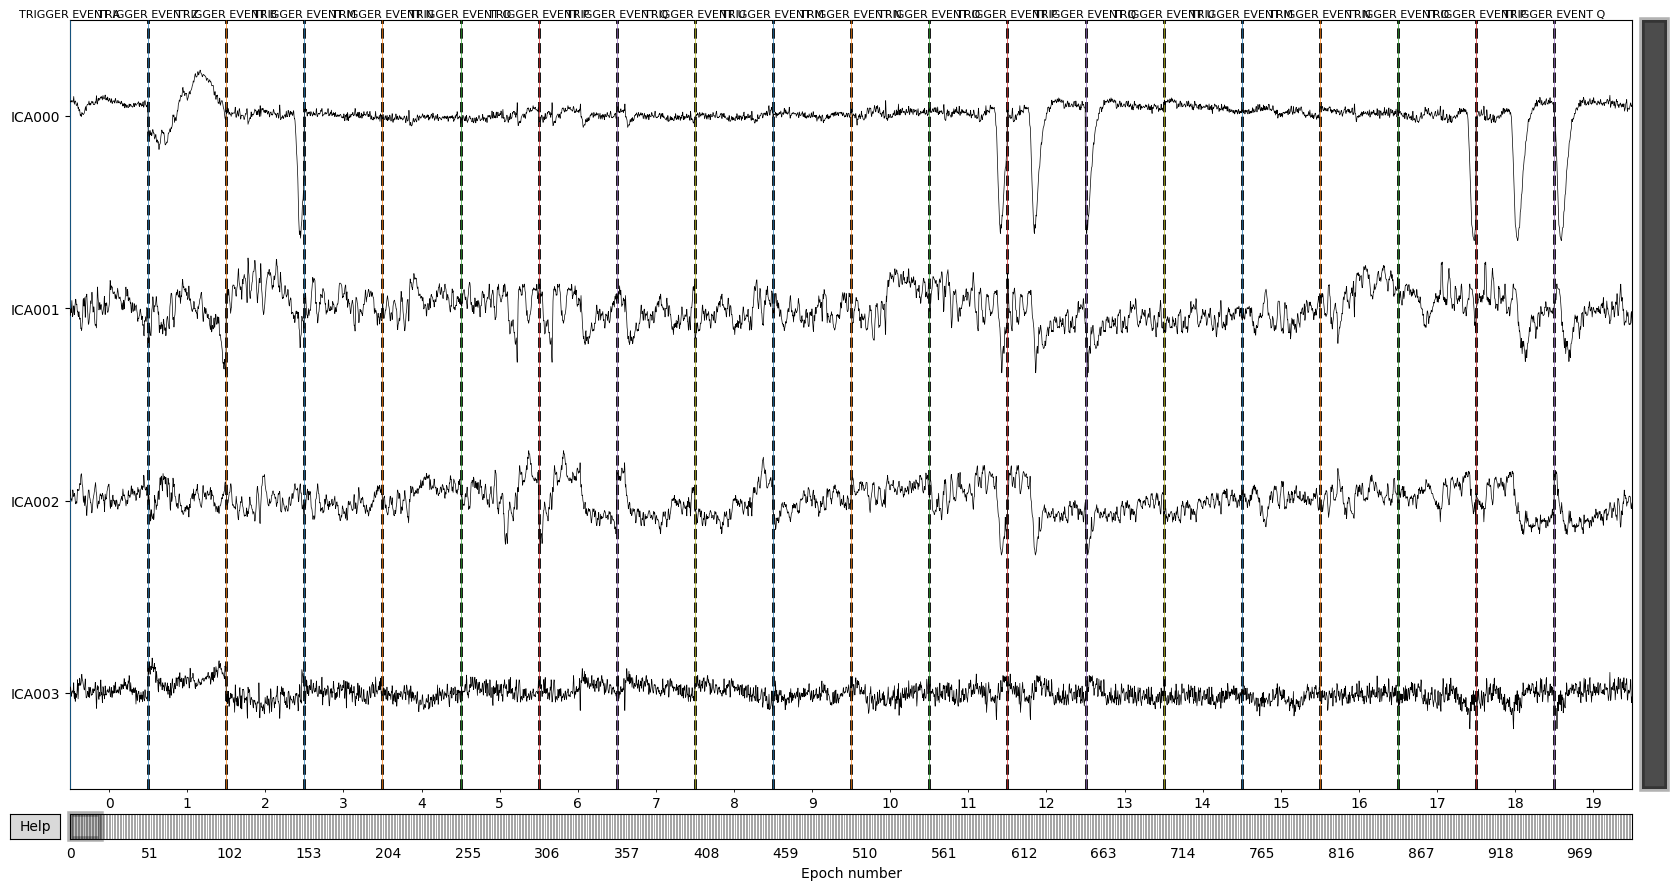

Applying ICA to Epochs instance
    Transforming to ICA space (4 components)
    Zeroing out 0 ICA components
    Projecting back using 4 PCA components
Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.1027 - loss: 3.1261 - val_accuracy: 0.1677 - val_loss: 3.1029
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.1893 - loss: 3.0464 - val_accuracy: 0.1677 - val_loss: 3.0574
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.1759 - loss: 2.7662 - val_accuracy: 0.1677 - val_loss: 2.9972
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.1749 - loss: 2.5059 - val_accuracy: 0.1677 - val_loss: 2.9369
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.1630 - loss: 2.4162 - val_accuracy: 0.1677 - val_loss: 2.8873
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.1522 - loss: 2.3110 - val_accuracy: 0.1677 - val_loss: 2.8324
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.1402 - loss: 

In [44]:
apply_cnn_pipeline(edf_file_path)